<a href="https://colab.research.google.com/github/christiansopov-gif/OMXS30_Projekt/blob/main/OMXS30_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Steg 1: Projekt Förutsäga rörelser i OMXS30 med AI**

**Projektidé**

Syftet är att undersöka om det går att använda maskininlärning för att förutsäga dagliga rörelser i OMXS30-indexet utifrån historisk data.
Målet är att förstå hur man hämtar, bearbetar och analyserar finansiell tidsseriedata och i nästa steg bygga en enkel modell som förutsäger om indexet går upp eller ner nästa handelsdag.

**Problemformulering**

Kan historiska mönster i OMXS30 ge en indikation på om marknaden stiger eller faller nästa dag?

**Typ av problem**

Klassificeringsproblem
(1 = uppgång, 0 = nedgång)

**Datakälla**

Data hämtas från Yahoo Finance med biblioteket yfinance
Ticker: OMX

Data innehåller kolumnerna:

Open = öppningskurs

High = högsta kurs

Low = lägsta kurs

Close = stängningskurs

Volume = omsättning

In [26]:
#KODCELL 1

# Importera de bibliotek vi behöver
import yfinance as yf        # För att hämta aktiedata direkt från Yahoo Finance
import pandas as pd           # För att hantera och analysera data i tabellform (DataFrames)
import matplotlib.pyplot as plt  # För att skapa grafer och visualiseringar

# Hämta historisk data för OMXS30 från Yahoo Finance
# ^OMX = OMXS30-indexet
# Vi hämtar data från 2015 till 2024
data = yf.download("^OMX", start="2015-01-01", end="2024-12-31", progress=False)

# Skriver ut hur många rader (dagar) datat innehåller
print("Antal rader:", len(data))

# Visar de första raderna i tabellen för att se hur datat ser ut
data.head()


Antal rader: 2511


/tmp/ipython-input-3162134799.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^OMX", start="2015-01-01", end="2024-12-31", progress=False)


Price,Close,High,Low,Open,Volume
Ticker,^OMX,^OMX,^OMX,^OMX,^OMX
Date,,,,,
2015-01-02,1463.780029,1472.609985,1460.670044,1470.550049,0
2015-01-05,1454.810059,1467.689941,1453.530029,1460.890015,0
2015-01-07,1421.339966,1441.310059,1421.339966,1432.300049,0
2015-01-08,1456.719971,1458.170044,1428.540039,1439.199951,0
2015-01-09,1444.459961,1460.989990,1439.150024,1453.510010,0


In [27]:
#KODCELL 2

# Undersök datat för att se datatyper och om något saknas

# Visar vilka datatyper varje kolumn har (float, int, datetime etc.)
print("\nDatatyper:\n", data.dtypes)

# Visar hur många saknade värden (NaN) som finns per kolumn
print("\nSaknade värden per kolumn:\n", data.isnull().sum())

# Visar grundläggande statistik (medelvärde, min, max, standardavvikelse etc.)
data.describe()



Datatyper:
 Price   Ticker
Close   ^OMX      float64
High    ^OMX      float64
Low     ^OMX      float64
Open    ^OMX      float64
Volume  ^OMX        int64
dtype: object

Saknade värden per kolumn:
 Price   Ticker
Close   ^OMX      0
High    ^OMX      0
Low     ^OMX      0
Open    ^OMX      0
Volume  ^OMX      0
dtype: int64


Price,Close,High,Low,Open,Volume
Ticker,^OMX,^OMX,^OMX,^OMX,^OMX
count,2511.000000,2511.000000,2511.000000,2511.000000,2.511000e+03
mean,1849.864818,1860.973503,1837.683301,1849.826212,1.405814e+07
std,370.955796,371.893376,369.840805,370.919555,3.724420e+07
min,1246.099976,1286.670044,1240.680054,1247.000000,0.000000e+00
25%,1557.895020,1567.630005,1546.565002,1557.135010,0.000000e+00
50%,1687.170044,1695.939941,1675.969971,1687.689941,0.000000e+00
75%,2200.425049,2210.294922,2189.285034,2201.665039,0.000000e+00
max,2642.429932,2649.919922,2632.409912,2644.800049,3.050086e+08


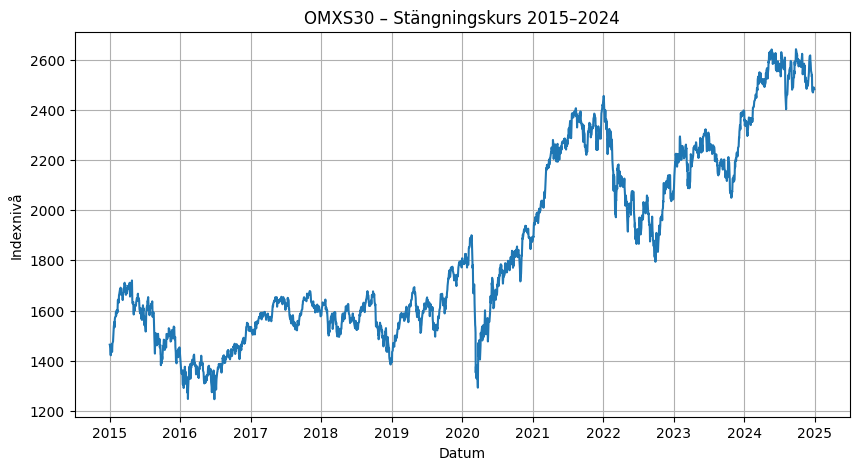

In [28]:
#KODCELL 3

#Rita graf över stängningskursen
# Skapar en figur i storleken 10x5 tum
plt.figure(figsize=(10,5))

# Plottar stängningskursen ("Close") över tid
plt.plot(data.index, data["Close"])

# Titel och etiketter
plt.title("OMXS30 – Stängningskurs 2015–2024")
plt.xlabel("Datum")
plt.ylabel("Indexnivå")

# Visar rutnät i bakgrunden för att lättare läsa grafen
plt.grid(True)

# Visar grafen
plt.show()



In [29]:
# Kodcell 4: Skapa nya kolumner för avkastning och målvariabel (fixad)

# 1) Platta till kolumner om de är MultiIndex (t.ex. "Close  ^OMX")
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 2) Ta bort ev. gamla kolumner från tidigare försök
for col in ["Return", "Target"]:
    if col in data.columns:
        data = data.drop(columns=col)

# 3) Räkna avkastning på stängningskurs
data["Return"] = data["Close"].pct_change()

# 4) Målvariabel: 1 om NÄSTA dags avkastning > 0, annars 0
data["Target"] = (data["Return"].shift(-1) > 0).astype(int)

# 5) Droppa bara rader där våra nya kolumner är NaN (inte hela raden på allt)
data = data.dropna(subset=["Return", "Target"])

print("Antal observationer efter rensning:", len(data))
data.head()


Antal observationer efter rensning: 2510


Price,Close,High,Low,Open,Volume,Return,Target
Date,,,,,,,
2015-01-05,1454.810059,1467.689941,1453.530029,1460.890015,0,-0.006128,0
2015-01-07,1421.339966,1441.310059,1421.339966,1432.300049,0,-0.023007,1
2015-01-08,1456.719971,1458.170044,1428.540039,1439.199951,0,0.024892,0
2015-01-09,1444.459961,1460.989990,1439.150024,1453.510010,0,-0.008416,1
2015-01-12,1453.640015,1460.109985,1444.550049,1455.540039,0,0.006355,1


In [30]:
#Kodcell 5: Kontrollera datakvalitet efter bearbetning

# Kollar om det finns några saknade värden kvar efter att vi skapat våra kolumner
print("Null-värden efter bearbetning:\n", data.isnull().sum())

# Rensar bort eventuella rader med null-värden (de första pga .pct_change())
data = data.dropna()

# Skriver ut hur många rader som återstår efter rensning
print("\nAntal observationer efter rensning:", len(data))


Null-värden efter bearbetning:
 Price
Close     0
High      0
Low       0
Open      0
Volume    0
Return    0
Target    0
dtype: int64

Antal observationer efter rensning: 2510


Fördelning av målvariabel (Target):
Nedgång (0): 1187 dagar
Uppgång  (1): 1323 dagar


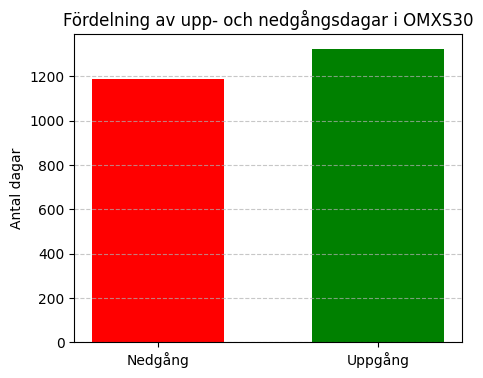

In [31]:
# Kodcell 5: Visa hur många dagar som var uppgång respektive nedgång

# Räkna antal förekomster av 0 och 1
count = data["Target"].value_counts().sort_index()

# Skriv ut siffrorna i textform
print("Fördelning av målvariabel (Target):")
print(f"Nedgång (0): {count.get(0, 0)} dagar")
print(f"Uppgång  (1): {count.get(1, 0)} dagar")

# Rita ett enkelt stapeldiagram
plt.figure(figsize=(5,4))
plt.bar(count.index, count.values, color=["red","green"], width=0.6)
plt.xticks([0,1], ["Nedgång","Uppgång"])
plt.title("Fördelning av upp- och nedgångsdagar i OMXS30")
plt.ylabel("Antal dagar")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
